# Hotel sentiment analysis

## Data exploration

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [51]:
df_dev = pd.read_csv("development.csv")
df_eval = pd.read_csv("evaluation.csv")

df_dev_count = df_dev.shape[0]
df_eval_count = df_eval.shape[0]

print(f"Development set: {df_dev.shape}, evaluation set: {df_eval.shape}")
print(f"Total number of rows: {df_dev_count + df_eval_count}")

Development set: (28754, 2), evaluation set: (12323, 1)
Total number of rows: 41077


### Missing values

In [16]:
print(f"Missing values (development): {df_dev.isnull().sum().sum()}")
n_empty = df_dev[df_dev['text'] == ""].shape[0]
print(f"Number of empty reviews (development): {n_empty}")

Missing values (development): 0
Number of empty reviews (development): 0


In [17]:
print(f"Missing values (evaluation): {df_eval.isnull().sum().sum()}")
n_empty = df_eval[df_eval['text'] == ""].shape[0]
print(f"Number of empty reviews (evaluation): {n_empty}")

Missing values (evaluation): 0
Number of empty reviews (evaluation): 0


The development and evaluation datasets do not contain any missing value or empty string.

### Class distribution

In [18]:
classes = set(df_dev['class'])
classes

{'neg', 'pos'}

There are only two classes in the dataset:
- `pos` expresses a positive sentiment;
- `neg` expresses a negative sentiment.

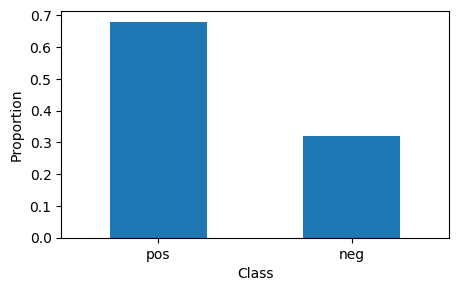

In [55]:
class_count = df_dev['class'].value_counts(normalize=True)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax = class_count.plot.bar(rot=0)
ax.set(xlabel="Class", ylabel="Proportion")
plt.show()

In [12]:
class_count

pos    0.679279
neg    0.320721
Name: class, dtype: float64

The dataset contains more positive reviews than negative ones: 68% of reviews are labeled `pos`, while 32% of reviews are labeled `neg`.

### Text contents

In [21]:
special_chars = ["\n", "\r", "\t"]
count = 0
for c in special_chars:
    c_count = df_dev['text'].str.contains(c).sum()
    if c_count > 0:
        count += c_count

count

13375

Some review texts contain special characters which should be deleted.

## Preprocessing

### Tokenization with stemmer

In [20]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import ItalianStemmer
from nltk.corpus import stopwords
import emoji
import re

stemmer = ItalianStemmer()
stopwords = set(stopwords.words('italian')) - {"non"} | {"hotel"}

re_alphabet = re.compile('[^a-zA-Z]') # Matches any non-alphabet character

# Punctuation tokens to save
punctuation = {'?', '!', '€', '$'}

def spell(s):
    count = 0
    pc = ''
    ns = ''
    
    # Correct characters repeating more than twice
    for c in s:
        if pc == c:
            count += 1
        else:
            count = 1

        if count <= 2:
            ns += c

        pc = c
    
    return ns

def tokenizer(s):
    tokens = []
    
    for token in word_tokenize(s):
        token = re.split("(\W+|\d+)", token) # Split tokens on any non-alphanumeric character (e.g. apostrophes)
        
        for t in token:
            emojis = emoji.emoji_lis(t) # handle emoji tokens
            if len(emojis) > 0:
                for e in emojis:
                    tokens.append(emoji.demojize(e['emoji']))
                continue
            
            if t not in punctuation:
                t = re_alphabet.sub('', t) # Delete non-alphabetic characters
                
                if len(t) < 3 or len(t) > 20:
                    continue
            
            t = spell(t)
            
            if t in stopwords:
                continue
            
            t = stemmer.stem(t)
            tokens.append(t)
        
    return tokens

#### Tokenizer testing

In [21]:
s = "Questo è un testo di prova! Prooovaaa! Funziona anche per caratteri speciali: /()!?€$!! €100"
tokenizer(s)

['quest',
 'test',
 'prov',
 '!',
 'proova',
 '!',
 'funzion',
 'caratter',
 'special',
 '!',
 '?',
 '€',
 '$',
 '!',
 '!',
 '€']

### Feature extraction

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer

start_time = time.time()

vectorizer = TfidfVectorizer(input='content', tokenizer=tokenizer, lowercase=True, min_df=2, max_features=15000, ngram_range=(1,2))

X = vectorizer.fit_transform(df_dev['text'])
X_eval = vectorizer.transform(df_eval['text'])

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:05:10


### Feature exploration

In [25]:
X # without max_features

<28754x198584 sparse matrix of type '<class 'numpy.float64'>'
	with 2828015 stored elements in Compressed Sparse Row format>

In [27]:
X # with max_features

<28754x15000 sparse matrix of type '<class 'numpy.float64'>'
	with 2090118 stored elements in Compressed Sparse Row format>

#### Wordclouds

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(background_color='white', width=1200, height=800)

def word_frequency(X, word_index):
    """Generate a dictionary that maps words to their frequency.
    
    :input X: sparse matrix with count values
    :word_index: dictionary (string to int) that maps words to column ids of X
    :return word_frequency: dictionary (string to float) that maps words to frequency
    """
    
    X_count = np.squeeze(np.asarray(X.sum(axis=0))) # array with shape (n_features,)
    X_total = X_count.sum()
    word_frequency = {k: X_count[v]/X_total for k,v in word_index.items()}
    
    return word_frequency

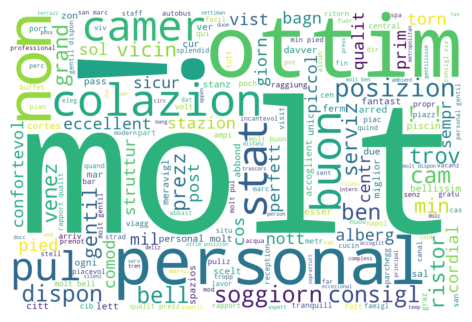

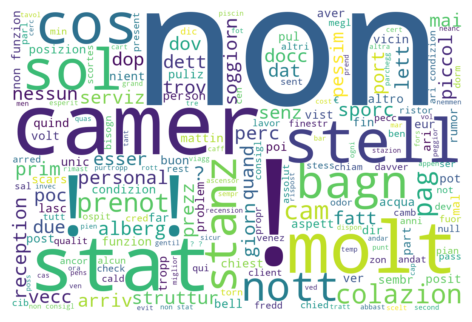

In [64]:
for c in classes:
    idx = df_dev[df_dev['class']==c].index
    f = word_frequency(X[idx], vectorizer.vocabulary_)
    
    wordcloud = wc.generate_from_frequencies(f)

    fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

#### Word distribution

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
fvectorizer = CountVectorizer(input='content')#, tokenizer=tokenizer, lowercase=True)
fX = fvectorizer.fit_transform(df_dev['text'])
X_count = np.squeeze(np.asarray(fX.sum(axis=0)))
f = {k: X_count[v] for k,v in fvectorizer.vocabulary_.items()}
of = [v for k, v in sorted(f.items(), key=lambda item: -item[1])]

In [ ]:
fX.toarray()

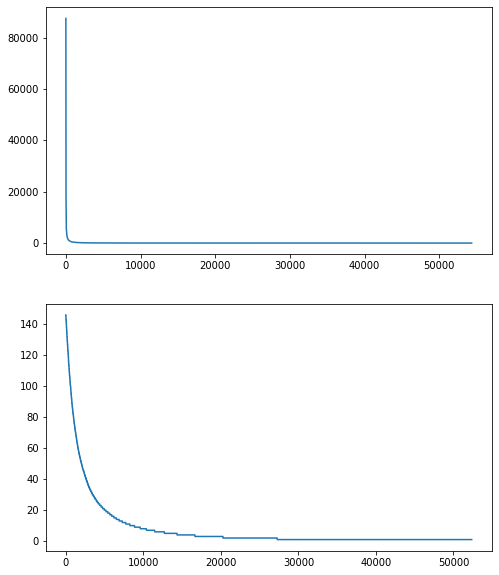

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(of)
ax[1].plot(of[2000:])
plt.show()

### Dimensionality reduction

In [36]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=8000, random_state=42)
X_svd = svd.fit_transform(X)
svd.explained_variance_ratio_.sum()

0.9187171567507351

In [37]:
X_svd_eval = svd.transform(X_eval)

## Classification algorithm

### Algorithm execution (Complement Naive Bayes)

In [48]:
from sklearn.naive_bayes import ComplementNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

X_nb = scaler.fit_transform(X_svd)
X_nb_eval = scaler.transform(X_eval)

clf = ComplementNB()
clf.fit(X_nb, df_dev['class'])
y_pred = clf.predict(X_nb_eval)

### Algorithm execution with grid search

In [42]:
from sklearn.svm import SVC

In [7]:
from sklearn.model_selection import GridSearchCV

start_time = time.time()

params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

svc = SVC(random_state=42)
clf = GridSearchCV(svc, param_grid=params, scoring='f1_weighted', cv=5, n_jobs=3)
clf.fit(X, df_dev['class'])

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

06:39:21


In [18]:
pd.DataFrame(clf.cv_results_)
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [ ]:
start_time = time.time()

clf = SVC(C=10, kernel='rbf', random_state=42)
clf.fit(X, df_dev['class'])
y_pred = clf.predict(X_eval)

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

### Algorithm execution (with CV)

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score

clf = ComplementNB()
f1_cv = cross_val_score(clf, X, df_dev['class'], cv=5, scoring='f1_weighted')

print(f"Macro-f1 for each iteration: {f1_cv}")
mean_macro_f1 = f1_cv.mean()
std_macro_f1 = f1_cv.std() * 2
print(f"Macro-f1 (statistics): {mean_macro_f1:.5f} (+/- {std_macro_f1:.5f})")

### Train test split and validation

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

X_train, X_test, \
y_train, y_test = train_test_split(X, df_dev['class'], test_size=0.2, stratify=df_dev['class'], random_state=42)

clfsvc = SVC(C=10, kernel='rbf', random_state=42)
clfsvc.fit(X_train, y_train)
y_pred = clfsvc.predict(X_test)

In [59]:
print(confusion_matrix(y_test, y_pred))

[[1733  111]
 [  87 3820]]


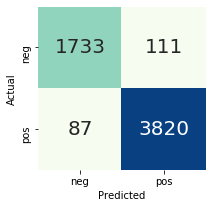

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)

conf_mat = [[1733,  111], [  87, 3820]]
label_names = ["neg", "pos"]
conf_mat_df = pd.DataFrame(conf_mat, index = label_names, columns = label_names)
conf_mat_df.index.name = 'Actual'
conf_mat_df.columns.name = 'Predicted'
sns.heatmap(conf_mat_df, annot=True, cmap='GnBu', 
            annot_kws={"size": 20}, fmt='g', cbar=False)

In [61]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

         neg     0.9522    0.9398    0.9460      1844
         pos     0.9718    0.9777    0.9747      3907

    accuracy                         0.9656      5751
   macro avg     0.9620    0.9588    0.9603      5751
weighted avg     0.9655    0.9656    0.9655      5751



### Data export

In [49]:
pd.DataFrame({'Id': range(0, len(y_pred)), 'Predicted': y_pred}).to_csv('prediction.csv', sep=',', index=False)